<a href="https://colab.research.google.com/github/nithecs-biomath/mini-schools/blob/main/cube_prac_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BUILDING DATA CUBES
## NITheCS mini school: lecture 2

### Install missing packages

In [1]:
%pip install pygbif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 83.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 3.3 MB/s eta 0:00:00


### Only execute the following block when using the TPU kernel

In [1]:
%pip install geopandas
%pip install pydrive
%pip install ee
%pip install eerepr
%pip install geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.4 MB/s eta 0:00:00
  Created wheel for pydrive: filename=pydrive-1.3.1-py3-none-any.whl size=27539 sha256=a0848b049e2b58ef30c570f585ad8a9e9153a01a48f5b0c4b0bd9f1f0ad9e409
  Stored in directory: /root/.cache/pip/wheels/31/d5/09/88865e0059104686eb8365ca1d36a8b27deef34232c3b62c90
Successfully built pydrive
  Installing build dependen

### Loading packages

In [7]:
from pygbif import occurrences as occ
import pandas as pd
import geopandas as gpd
from pyproj import Proj, Transformer
from shapely.geometry import mapping
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials
import io
import zipfile
import math

### Loading Earth Engine

In [8]:
import ee
import eerepr
import geemap

ee.Authenticate(force=True)
ee.Initialize(project='nithecs-436810')

LANDSAT_ID = "LANDSAT/LC08/C02/T1_L2"
BOUNDARIES_ID = 'FAO/GAUL/2015/level1'
WDPA_ID = 'WCMC/WDPA/current/polygons'
SENTINEL_ID = "COPERNICUS/S2_SR_HARMONIZED"


dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2021-05-01', '2021-06-01')
sa = ee.FeatureCollection(BOUNDARIES_ID).filter(
    'ADM0_NAME == "South Africa"')

dataset_eo = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate('2020-01-01', '2020-01-30')

protected_areas = ee.FeatureCollection(WDPA_ID)


sa_landsat = dataset.filterBounds(sa)
sa_sentinel = dataset_eo.filterBounds(sa)


### Example of the GBIF API through pygbif

In [ ]:
from pygbif import occurrences
data = occurrences.search(speciesKey=5229490, limit=10)

print(data['results'])

[{'key': 5000579471, 'datasetKey': 'df12ca07-f133-4550-ab3b-fde13f0e76ba', 'publishingOrgKey': '04fd2e13-6881-4e5c-9dd1-8fdd9ab993c1', 'installationKey': 'b1304814-56cc-434e-8d40-2b24fa21526f', 'hostingOrganizationKey': '04fd2e13-6881-4e5c-9dd1-8fdd9ab993c1', 'publishingCountry': 'FI', 'protocol': 'EML', 'lastCrawled': '2025-01-04T01:53:52.478+00:00', 'lastParsed': '2025-01-04T02:29:30.775+00:00', 'crawlId': 276, 'extensions': {}, 'basisOfRecord': 'HUMAN_OBSERVATION', 'individualCount': 1, 'occurrenceStatus': 'PRESENT', 'taxonKey': 5229490, 'kingdomKey': 1, 'phylumKey': 44, 'classKey': 212, 'orderKey': 729, 'familyKey': 5235, 'genusKey': 7237083, 'speciesKey': 5229490, 'acceptedTaxonKey': 5229490, 'scientificName': 'Pica pica (Linnaeus, 1758)', 'acceptedScientificName': 'Pica pica (Linnaeus, 1758)', 'kingdom': 'Animalia', 'phylum': 'Chordata', 'order': 'Passeriformes', 'family': 'Corvidae', 'genus': 'Pica', 'species': 'Pica pica', 'genericName': 'Pica', 'specificEpithet': 'pica', 'taxo

## GBIF data Cubes

### Generating the Cube

#### Exemplar JSON query for generating a data *cube*



```
{
  "sendNotification": true,
  "notificationAddresses": [
    "maarten.trekels@plantentuinmeise.be"
  ],
  "format": "SQL_TSV_ZIP",
  "sql": "SELECT  PRINTF('%04d-%02d', \"year\", \"month\") AS yearMonth,
   GBIF_EEARGCode(10000, decimalLatitude,  decimalLongitude,  COALESCE(coordinateUncertaintyInMeters, 1000) ) AS eeaCellCode,
   speciesKey,
   species,
   establishmentMeans,
   degreeOfEstablishment,
   pathway,
   COUNT(*) AS occurrences,
   COUNT(DISTINCT recordedBy) AS distinctObservers
   FROM  occurrence
   WHERE occurrenceStatus = 'PRESENT'
   AND countryCode = 'BE'
   AND hasCoordinate = TRUE
   AND NOT ARRAY_CONTAINS(issue, 'ZERO_COORDINATE')
   AND NOT ARRAY_CONTAINS(issue, 'COORDINATE_OUT_OF_RANGE')
   AND NOT ARRAY_CONTAINS(issue, 'COORDINATE_INVALID')
   AND NOT ARRAY_CONTAINS(issue, 'COUNTRY_COORDINATE_MISMATCH')
   AND \"month\" IS NOT NULL
   GROUP BY yearMonth,
   eeaCellCode,
   speciesKey,
   species,
   establishmentMeans,
   degreeOfEstablishment,
   pathway
   ORDER BY  yearMonth DESC,
   eeaCellCode ASC,
   speciesKey ASC"
}
```



#### Using the GBIF Download UI

https://techdocs.gbif.org/en/data-use/api-sql-downloads

## Loading the Data cube in pandas



#### Download from GitHub

You can download a pre generated data cube from GitHub or any other online resource

In [ ]:
#data = pd.read_csv('https://raw.githubusercontent.com/nithecs-biomath/mini-schools/refs/heads/main/data/sample_data_SA.csv', sep='\t')

#print(data)

#### Download from Google Drive

In [ ]:
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/Shareddrives/NiTheCS mini school/demo_data/Cube_ZA_QDGC_l3.csv', sep='\t')


Mounted at /content/drive


In [ ]:
print(data)

         yearmonth    qdgccode  familykey        family  specieskey  \
0          2024-09  E016S28ADD     2406.0  Crassulaceae   7716880.0   
1          2024-09  E016S28BCC     2406.0  Crassulaceae   7716880.0   
2          2024-09  E016S28BDD     4676.0   Geraniaceae   3826148.0   
3          2024-09  E016S28BDD     2406.0  Crassulaceae   7334236.0   
4          2024-09  E016S28CBB     6752.0     Aizoaceae   8003531.0   
...            ...         ...        ...           ...         ...   
17876161   1772-04  E025S28CCC     7689.0   Orchidaceae   2783834.0   
17876162   1694-10  E027S32DBB     2430.0    Onagraceae   3188875.0   
17876163   1678-02  E028S25DCB     7359.0     Araneidae         NaN   
17876164   1645-12  E030S30BBC     7016.0  Notodontidae   1824935.0   
17876165   1608-10  E023S33ABC     4334.0        Apidae   5040145.0   

                             species  occurrences  familycount  
0                  Crassula sladenii            1      44434.0  
1                

## Getting a Geopackage file from the Grid that you use

In [ ]:
# Load QDGC code

input_file = "/content/drive/Shareddrives/NiTheCS mini school/demo_data/qdgc_south_africa.gpkg"

qdgc_ref = gpd.read_file(input_file, layer='tbl_qdgc_03')

In [ ]:
print(qdgc_ref)

             qdgc  level_qdgc  cellsize_degrees  lon_center  lat_center  \
0      E016S46CDD           3             0.125     16.4375    -46.9375   
1      E016S46CDB           3             0.125     16.4375    -46.8125   
2      E016S46CBD           3             0.125     16.4375    -46.6875   
3      E016S46CBB           3             0.125     16.4375    -46.5625   
4      E016S46ADD           3             0.125     16.4375    -46.4375   
...           ...         ...               ...         ...         ...   
34422  E037S22DBD           3             0.125     37.9375    -22.6875   
34423  E037S22DBB           3             0.125     37.9375    -22.5625   
34424  E037S22BDD           3             0.125     37.9375    -22.4375   
34425  E037S22BDB           3             0.125     37.9375    -22.3125   
34426  E037S22BBD           3             0.125     37.9375    -22.1875   

         area_km2                                           geometry  
0      132.265148  MULTIPOLY

## Merging the Data cube with the grid

In [ ]:
#testing if I can merge data and qdgc

test_merge = pd.merge(data, qdgc_ref, left_on='qdgccode', right_on='qdgc')

print(test_merge)


         yearmonth    qdgccode  familykey        family  specieskey  \
0          2024-09  E016S28ADD     2406.0  Crassulaceae   7716880.0   
1          2024-09  E016S28BCC     2406.0  Crassulaceae   7716880.0   
2          2024-09  E016S28BDD     4676.0   Geraniaceae   3826148.0   
3          2024-09  E016S28BDD     2406.0  Crassulaceae   7334236.0   
4          2024-09  E016S28CBB     6752.0     Aizoaceae   8003531.0   
...            ...         ...        ...           ...         ...   
17829560   1772-04  E025S28CCC     7689.0   Orchidaceae   2783834.0   
17829561   1694-10  E027S32DBB     2430.0    Onagraceae   3188875.0   
17829562   1678-02  E028S25DCB     7359.0     Araneidae         NaN   
17829563   1645-12  E030S30BBC     7016.0  Notodontidae   1824935.0   
17829564   1608-10  E023S33ABC     4334.0        Apidae   5040145.0   

                             species  occurrences  familycount        qdgc  \
0                  Crassula sladenii            1      44434.0  E016S

In [ ]:
# Convert to GeoDataFrame

gdf = gpd.GeoDataFrame(test_merge, geometry='geometry')


In [ ]:
# set the CRS and convert to a GeoParquet file
gdf = gdf.set_crs(epsg=4326, inplace=False)

gdf.to_parquet('/content/drive/Shareddrives/NiTheCS mini school/demo_data/data_ZA.parquet')

## Loading data directly as Parquet files


In [14]:
drive.mount('/content/drive')

gbif_cube = '/content/drive/Shareddrives/NiTheCS mini school/demo_data/data_ZA.parquet'
gbif_points = '/content/drive/Shareddrives/NiTheCS mini school/demo_data/data_ZA_occurrence.parquet'

gdf_cube = gpd.read_parquet(gbif_cube)
gdf_point = gpd.read_parquet(gbif_points)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Filtering data (e.g. on species)

Check for a single species (Acacia implexa Benth.: https://www.gbif.org/species/2979232)



In [15]:
#check for a single species
gdf_cube = gdf_cube[gdf_cube['specieskey'].eq(2979232)]
gdf_point = gdf_point[gdf_point['speciesKey'].eq(2979232.0)]


## Apply the function to create a list of features

In [16]:
# Convert GeoDataFrames to GeoJSON FeatureCollections
def gdf_to_ee_featurecollection(gdf):
    return geemap.geopandas_to_ee(gdf, geodesic=False)

# Assuming gdf1 and gdf2 are your GeoDataFrames
fc1 = gdf_to_ee_featurecollection(gdf_cube)
fc2 = gdf_to_ee_featurecollection(gdf_point)

## Visualization of the data cubes on a map with different layers

In [17]:
# Create a map centered on your data
center = (-33.97, 18.58)

Map = geemap.Map(layout={"height": "500px", "width": "1000px"}, center=center, zoom=10)


visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

# Add FeatureCollections to the map
Map.addLayer(fc1, {'color': 'red'}, 'Data Cube')
Map.addLayer(fc2, {'color': 'blue'}, 'Point data')


#Map.addLayer(sa_sentinel, visualization, 'RGB Sentinel 2')

#Map.addLayer(protected_areas)


# Visualise the map
Map

Map(center=[-33.97, 18.58], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [ ]:
### Test with NetCDF format

# EBV data cubes in NetCDF format

https://portal.geobon.org/datasets

In [29]:
%pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.1 MB/s eta 0:00:00


In [30]:
%pip install rioxarray
%pip install cartopy
%pip install basemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.4/942.4 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.1
    Uninstalling pyproj-3.7.1:
      Successfully uninstalled pyproj-3.7.1
  Attempting uninstall: packaging
    Found existing instal

In [1]:
import netCDF4 as nc
import xarray as xr


birds_file = xr.open_dataset('/content/drive/Shareddrives/NiTheCS mini school/demo_data/viti_spepop_id77_20240206_v1.nc')

print(birds_file)

<xarray.Dataset> Size: 26kB
Dimensions:  (lon: 559, lat: 437, time: 1, entity: 486)
Coordinates:
  * lon      (lon) float64 4kB 9.45e+05 9.55e+05 ... 6.515e+06 6.525e+06
  * lat      (lat) float64 3kB 5.305e+06 5.295e+06 ... 9.55e+05 9.45e+05
  * time     (time) datetime64[ns] 8B 2018-01-01
  * entity   (entity) |S37 18kB b'Gavia stellata                       ' ... ...
Data variables:
    crs      |S1 1B ...
Attributes: (12/38)
    Conventions:                CF-1.8, ACDD-1.3, EBV-1.0
    naming_authority:           The German Centre for Integrative Biodiversit...
    history:                    EBV netCDF created using ebvcube, 2024-02-06
    ebv_vocabulary:             https://portal.geobon.org/api/v1/ebv
    ebv_cube_dimensions:        lon, lat, time, entity
    keywords:                   ebv_class: Species populations, ebv_name: Spe...
    ...                         ...
    geospatial_lat_units:       meter
    time_coverage_start:        2013-01-01
    time_coverage_end:       

In [2]:
def print_netcdf_structure(nc_file_path):
  """Prints the structure (groups, variables, and their paths) of a NetCDF file.

  Args:
    nc_file_path: Path to the NetCDF file.
  """
  def print_group_structure(group, path=""):
    """Recursively prints the structure of a group within the NetCDF file."""
    for var_name in group.variables:
      print(f"{path}/{var_name}")  # Print variable path
    for group_name in group.groups:
      subgroup = group.groups[group_name]
      print_group_structure(subgroup, f"{path}/{group_name}")  # Recursively explore subgroups

  with nc.Dataset(nc_file_path, 'r') as nc_file:
    print_group_structure(nc_file)  # Start with the root group

# Example usage:
nc_file_path = '/content/drive/Shareddrives/NiTheCS mini school/demo_data/viti_spepop_id77_20240206_v1.nc'
print_netcdf_structure(nc_file_path)

/lon
/lat
/time
/crs
/entity
/metric_1/ebv_cube


In [3]:
print(birds_file.variables)

Frozen({'lon': <xarray.IndexVariable 'lon' (lon: 559)> Size: 4kB
array([ 945000.,  955000.,  965000., ..., 6505000., 6515000., 6525000.])
Attributes:
    long_name:      lon
    standard_name:  projection_x_coordinate
    axis:           X
    units:          meter, 'lat': <xarray.IndexVariable 'lat' (lat: 437)> Size: 3kB
array([5305000., 5295000., 5285000., ...,  965000.,  955000.,  945000.])
Attributes:
    long_name:      lat
    standard_name:  projection_y_coordinate
    axis:           Y
    units:          meter, 'time': <xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2018-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:  time
    axis:       T, 'crs': <xarray.Variable ()> Size: 1B
[1 values with dtype=|S1]
Attributes:
    spatial_ref:                     PROJCRS["ETRS89-extended / LAEA Europe",...
    GeoTransform:                    940000 10000 0.0 5310000 0.0 -10000
    grid_mapping_name:               lambert_azimuthal_equal_area
    l

In [4]:
time = birds_file.variables['time']
print(time)

print(birds_file['entity'])

<xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2018-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:  time
    axis:       T
<xarray.DataArray 'entity' (entity: 486)> Size: 18kB
array([b'Gavia stellata                       ',
       b'Gavia arctica                        ',
       b'Tachybaptus ruficollis               ', ...,
       b'Accipiter gentilis all others        ',
       b'Melanitta nigra s. str.              ',
       b'Sylvia subalpina                     '], dtype='|S37')
Coordinates:
  * entity   (entity) |S37 18kB b'Gavia stellata                       ' ... ...
Attributes:
    units:                           1
    ebv_entity_type:                 Species
    ebv_entity_scope:                Bird species listed under the Art. 12 of...
    ebv_entity_classification_name:  Species names as accepted by the Birds D...
    ebv_entity_classification_url:   https://cdr.eionet.europa.eu/help/birds_...
    long_name:                     

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


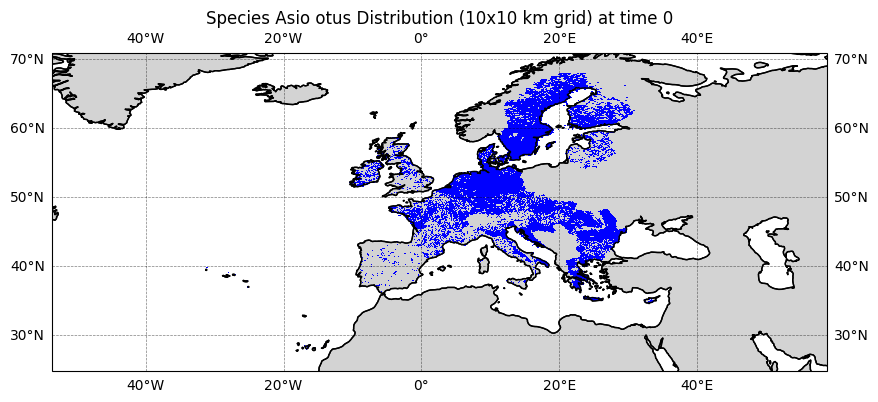

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
from pyproj import Transformer
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- Load Dataset Efficiently ---
birds_file = xr.open_dataset(
    '/content/drive/Shareddrives/NiTheCS mini school/demo_data/viti_spepop_id77_20240206_v1.nc',
    group="metric_1",
    chunks={'entity': 1, 'time': 1}  # Load only one entity/time slice at a time
)

# --- Select Target Species and Time ---
species_index = 150  # Change to the species index you need
time_index = 0  # Change to the desired time index

# Extract only the required slice
species_data_subset = birds_file['ebv_cube'].sel(entity=species_index, time=time_index).compute()

# Convert to a 2D array
species_distribution_2d = np.squeeze(species_data_subset)

# --- Load Longitude and Latitude (Only Once) ---
with xr.open_dataset('/content/drive/Shareddrives/NiTheCS mini school/demo_data/viti_spepop_id77_20240206_v1.nc') as ds:
    lon = ds['lon'].values  # 1D array (size: 559)
    lat = ds['lat'].values  # 1D array (size: 437)

# --- Create Meshgrid Efficiently ---
lon_grid, lat_grid = np.meshgrid(lon, lat)

# --- Efficient Coordinate Transformation ---
transformer = Transformer.from_crs("epsg:3035", "epsg:4326", always_xy=True)

# Transform the entire 2D meshgrid
lon_deg, lat_deg = transformer.transform(lon_grid, lat_grid)

# --- Create the Plot ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# --- 🔹 Fix: Use Discrete Colormap Without Color Bar ---
unique_values = np.unique(species_distribution_2d)

# If only one value, choose a single solid color
if len(unique_values) == 1:
    cmap = ListedColormap(["red"])  # Single-color for uniform data
    norm = None
else:
    cmap = ListedColormap(["white", "blue"])  # Adjust colors as needed
    norm = BoundaryNorm([0, 0.5, 1], cmap.N)

# --- 🔹 Fix: Use `shading="nearest"` to Ensure Correct Grid Alignment ---
cs = ax.pcolormesh(
    lon_deg, lat_deg, species_distribution_2d,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    shading='nearest'  # Prevents visual distortion
)

# --- 🔹 Completely Remove Color Bar ---
# No `fig.colorbar(cs)`, so no scale bar will be shown

# --- Get the Species Name Efficiently ---
with xr.open_dataset('/content/drive/Shareddrives/NiTheCS mini school/demo_data/viti_spepop_id77_20240206_v1.nc') as ds:
    species_name = ds['entity'].values[species_index].decode('utf-8').strip()

# --- Final Plot Customization ---
ax.set_title(f"Species {species_name} Distribution (10x10 km grid) at time {birds_file['time'].values[time_index].item()}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# --- 🔹 Fix: Add Grid Lines to Show Exact 10x10 km Cells ---
gridlines = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="black", alpha=0.5)

# Show the plot
plt.show()